**BUAN6341: Assignment 1**

_Adityan Rajendran - axr180073_

In [1192]:
# BUAN6341: Assignment 1
# Adityan Rajendran - axr180073

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as ss

%matplotlib inline

**TASKS BEGIN**

**TASK 1**

In [1193]:
## Tasks - Part 1
## Selection of features and partition of data

data = pd.read_csv('energydata_complete.csv')

target_col = ['Appliances']
temp_col = ['T1','T2','T3','T4','T5','T6','T7','T8','T9']
weather_col = ['T_out', 'Tdewpoint','RH_out','Press_mm_hg','Windspeed','Visibility']
hum_col = ['RH_1','RH_2','RH_3','RH_4','RH_5','RH_6','RH_7','RH_8','RH_9']
lights_col = ['lights']
rv_col = ['rv1','rv2']

dep_var = target_col
indep_var = temp_col + hum_col + weather_col + rv_col

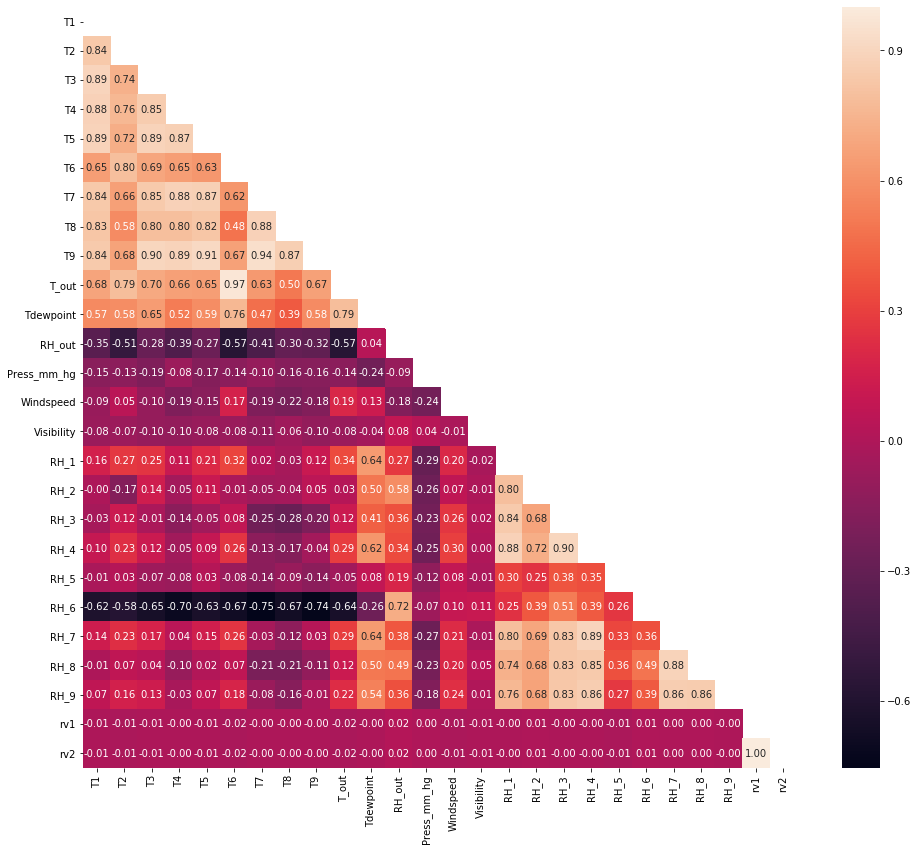

In [1194]:
# data pre-processing and correlation analysis to choose features for building regression
(data.lights == 0).sum()     #15252 zeroes present out of 19735 values

data_corr = data[temp_col + weather_col + hum_col + rv_col]
corr = data_corr.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = 1

f,ax = plt.subplots(figsize=(16,14))
ss.heatmap(corr, annot=True, fmt='.2f', mask=mask)
# Dropping 'date',lights','T6' (as T6 and To are same), 'T9' (T3,T5,T7,T9 are highly correlated) and 'rv'

In [1195]:
data_processed = data.copy(deep=True)
data_processed.drop(['date','lights','T6','T9','rv1','rv2'], axis=1, inplace=True)

In [1196]:
data_scaled = data_processed.copy(deep=True)
for col in data_processed.columns:
    data_scaled[col] = (data_processed[col] - data_processed[col].mean())/(data_processed[col].std())

In [1197]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data_scaled, test_size = 0.3, random_state = 40)

train_y = train[target_col]
train_x = train.loc[:, train.columns!='Appliances']

test_x = test.loc[:, test.columns!='Appliances']
test_y = test[dep_var]

**TASK 2 BEGINS**

In [1198]:
## Tasks - Part 2
## Linear Regression model
beta_start = 0.5
beta_0 = np.full((train_x.shape[0],1), beta_start)
beta = np.full((train_x.shape[1],1), beta_start)

train_X = train_x.to_numpy()
train_Y = train_y.to_numpy()

In [1199]:
# Linear Regression Model Function
def linear_regression_model(x, beta_0, beta):
    y_hat = (x @ beta) + beta_0
    return y_hat

**TASK 3 BEGINS**

In [1200]:
## Tasks - Part 3
## Gradient Descent Algorithm - Batch update rule

# COST function
# y_hat and y have same shape; They are matrices;
def cost(y_hat, y):     
    m = len(y_hat)
    ct = (0.5/m) * np.sum((y_hat - y)**2)
    return ct

In [1201]:
## Gradient Descent Function
def gradient_descent(epochs, alpha, thres, train_Y, train_X, beta_0_new, beta_new, flag):
    prev_cost = 100
    iters = 0
    for j in range(epochs):
        train_Y_hat_new = linear_regression_model(train_X, beta_0_new, beta_new)
        for i in range(len(beta_new)):
            se = np.sum((train_Y_hat_new - train_Y).T @ train_X[:,i:i+1])
            beta_new[i] = beta_new[i] - ((alpha/m) * se)   
        beta_0_new = beta_0_new - ((alpha/m) * np.sum(train_Y_hat_new - train_Y))
        c = cost(train_Y_hat_new, train_Y)
        #print("Iteration ",j,'; ','thres = ',thres,'; prev_cost = ',prev_cost,': Current cost = ',c)
        if((prev_cost - c) <= thres and flag == 0):
            #print("Threshold reached: Breaking out of loop...")
            return j, beta_0_new, beta_new, c
        prev_cost = c.copy() 
        #print(beta_0_new[0,0],'; ',beta_new.T)
        iters = j
    return iters, beta_0_new, beta_new, prev_cost

In [1202]:
print('Initial beta0 value: ', beta_0[0])
print('Initial beta values(apart from beta0): ', beta.T)

Initial beta0 value:  [0.5]
Initial beta values(apart from beta0):  [[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5]]


In [1203]:
## Linear Regression - Training set - Applying gradient descent
np.set_printoptions(precision=4)
beta_new = beta.copy()
beta_0_new = beta_0.copy()
alpha = 0.01
epochs = 100
thresh = 0.00001
flag = 0

iters_final, beta_0_final, beta_final, cost_value = gradient_descent(epochs, alpha, thresh, train_Y, train_X, beta_0_new, beta_new, flag)
print('Final beta values: ', beta_0_final[0,0],beta_final.T)
print('Final cost: ', cost_value,'; Iterations run: ',iters_final)

Final beta values:  0.1792209696572603 [[-0.0023  0.0292  0.1295 -0.0113  0.0775  0.0521  0.0909 -0.0555 -0.0107
   0.1324  0.4039  0.1495 -0.1179  0.1717 -0.1033 -0.0972  0.1817  0.362
   0.1906  0.3703  0.1903 -0.1121]]
Final cost:  0.6110751696844147 ; Iterations run:  99


In [1204]:
## Linear Regression - Test set
# Using linear regression model function, we can obtain the test set model by passing the beta parameters and X_test
test_X = test_x.to_numpy()
test_Y = test_y.to_numpy()
test_Y_hat = linear_regression_model(test_X, beta_0_final[0:len(test_X)], beta_final)

error = cost(test_Y_hat, test_Y)

**TASK 4 BEGINS**

In [1205]:
## Tasks - Part 4
## Logistic Regression - using SGDClassifier

data_logit = data.copy(deep=True)
data_logit.drop(['date','lights','T6','T9','rv1','rv2'], axis=1, inplace=True)

for col in data_logit.columns:
    if(col != 'Appliances'):
        data_logit[col] = (data_logit[col] - data_logit[col].mean())/(data_logit[col].std())

for i in range(len(data_logit['Appliances'])):
    if(data_logit['Appliances'].values[i] <= 60):
        data_logit['Appliances'].values[i] = 0
    else:
        data_logit['Appliances'].values[i] = 1
        
from sklearn.model_selection import train_test_split
train_logit, test_logit = train_test_split(data_logit, test_size = 0.3, random_state = 40)

logit_train_y = train_logit[target_col]
logit_train_x = train_logit.loc[:, train.columns!='Appliances']

logit_test_x = test_logit.loc[:, test.columns!='Appliances']
logit_test_y = test_logit[dep_var]

In [1206]:
## Logistic Regression model
def logistic_regression_model(train_x, train_y, test_x, alph):
    from sklearn import linear_model
    model = linear_model.SGDClassifier(alpha=alph, random_state=4)
    model.fit(train_x, train_y)

    y_hat = model.predict(test_x)
    return y_hat, model

alpha_logit = 0.00001
logit_y_hat, logit = logistic_regression_model(logit_train_x, logit_train_y, logit_test_x, alpha_logit)

acc_train = logit.score(logit_train_x, logit_train_y)
acc_test = logit.score(logit_test_x, logit_test_y)
print(acc_train, acc_test)

0.7202113797596641 0.7240331025164668


**EXPERIMENTATION BEGINS**

_EXPERIMENT - 1_

In [1207]:
## Experimentation
## Experiment - 1

# Linear Regression - for varying values of alpha; Fixed threshold at 0.00001 (Please see experiment 2 for the reason)
expt_train_cost_matrix = {}
expt_test_cost_matrix = {}
alph = [0.0001, 0.0003, 0.0005, 0.001, 0.005]
b_new = beta.copy()
b0_new = beta_0.copy()
thr = 0.00001
fl = 1

n = range(100,4100,500)
for i in alph:
    expt_itrain_matrix = []
    expt_itest_matrix = []
    for jj in n:
        b_new = beta.copy()
        b0_new = beta_0.copy()
        k,b0,b,c = gradient_descent(jj, i, thr, train_Y, train_X, b0_new, b_new, fl)
        expt_itrain_matrix.append([k,c])
        test_y_hat = linear_regression_model(test_X, b0[0:len(test_X)], b)
        expt_itest_matrix.append([k,cost(test_y_hat, test_Y)])
    expt_train_cost_matrix[i] = expt_itrain_matrix
    expt_test_cost_matrix[i] = expt_itest_matrix   

In [1208]:
x_11, y_11 = np.split(expt_train_cost_matrix[alph[0]],[-1],axis=1)
x_12, y_12 = np.split(expt_train_cost_matrix[alph[1]],[-1],axis=1)
x_13, y_13 = np.split(expt_train_cost_matrix[alph[2]],[-1],axis=1)
x_14, y_14 = np.split(expt_train_cost_matrix[alph[3]],[-1],axis=1)
x_15, y_15 = np.split(expt_train_cost_matrix[alph[4]],[-1],axis=1)

X_11, Y_11 = np.split(expt_test_cost_matrix[alph[0]],[-1],axis=1)
X_12, Y_12 = np.split(expt_test_cost_matrix[alph[1]],[-1],axis=1)
X_13, Y_13 = np.split(expt_test_cost_matrix[alph[2]],[-1],axis=1)
X_14, Y_14 = np.split(expt_test_cost_matrix[alph[3]],[-1],axis=1)
X_15, Y_15 = np.split(expt_test_cost_matrix[alph[4]],[-1],axis=1)

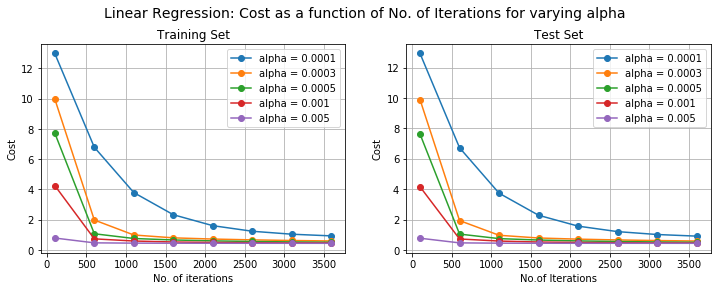

In [1209]:
figs, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
axes[0].plot(x_11, y_11, 'o-', label='alpha = 0.0001')
axes[0].plot(x_12, y_12, 'o-', label='alpha = 0.0003')
axes[0].plot(x_13, y_13, 'o-', label='alpha = 0.0005')
axes[0].plot(x_14, y_14, 'o-', label='alpha = 0.001')
axes[0].plot(x_15, y_15, 'o-', label='alpha = 0.005')
axes[0].set(xlabel='No. of iterations', ylabel='Cost',
       title='Training Set')
axes[0].grid()
axes[0].legend(loc="upper right")

axes[1].plot(X_11, Y_11, 'o-', label='alpha = 0.0001')
axes[1].plot(X_12, Y_12, 'o-', label='alpha = 0.0003')
axes[1].plot(X_13, Y_13, 'o-', label='alpha = 0.0005')
axes[1].plot(X_14, Y_14, 'o-', label='alpha = 0.001')
axes[1].plot(X_15, Y_15, 'o-', label='alpha = 0.005')
axes[1].set(xlabel='No.of Iterations', ylabel='Cost',
       title='Test Set')
axes[1].grid()
axes[1].legend(loc="upper right")
figs.suptitle('Linear Regression: Cost as a function of No. of Iterations for varying alpha', fontsize=14)
figs.subplots_adjust(top=0.85)
#figs.savefig("expt1_linear.png")

In [1210]:
# Logistic Regression - for varying values of alpha
import warnings
warnings.filterwarnings('ignore')

expt_logit_train_acc = {}
expt_logit_accuracy_matrix = {}
alpha_logit1 = [0.0001, 0.0003, 0.0008, 0.001, 0.005, 0.007, 0.01]
for i in alpha_logit1:
    logit_Y_hat, logit_model = logistic_regression_model(logit_train_x, logit_train_y, logit_test_x, i)
    sc_train = logit_model.score(logit_train_x, logit_train_y)
    sc_test = logit_model.score(logit_test_x, logit_test_y)
    expt_logit_train_acc[i] = sc_train
    expt_logit_accuracy_matrix[i] = sc_test

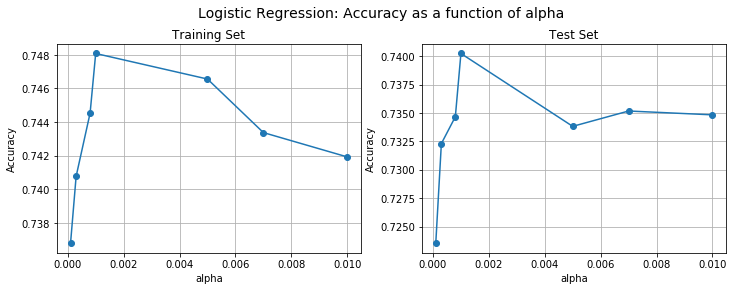

In [1211]:
lists_logit1 = sorted(expt_logit_train_acc.items())
x11_l, y11_l = zip(*lists_logit1)
lists_logit2 = sorted(expt_logit_accuracy_matrix.items())
x12_l, y12_l = zip(*lists_logit2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax[0].plot(x11_l, y11_l, 'o-')
ax[0].set(xlabel='alpha', ylabel='Accuracy',
       title='Training Set')
ax[0].grid()

ax[1].plot(x12_l, y12_l, 'o-')
ax[1].set(xlabel='alpha', ylabel='Accuracy',
       title='Test Set')
ax[1].grid()

fig.suptitle('Logistic Regression: Accuracy as a function of alpha', fontsize=14)
fig.subplots_adjust(top=0.85)
#fig.savefig("expt1_logit.png")
plt.show()

**EXPERIMENT - 2 BEGINS**

In [1212]:
## Experiment - 2
thresh_set = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01]

alpha_2 = 0.001
epochs = 100000

expt2_cost_matrix_train = {}
expt2_cost_matrix_test = {}

for i in thresh_set:
    beta_2 = beta.copy()
    beta0_2 = beta_0.copy()
    iter2, b0_2,b2,c2 = gradient_descent(epochs, alpha_2, i, train_Y, train_X, beta0_2, beta_2, flag)
    expt2_cost_matrix_train[i] = c2
    test2_y_hat = linear_regression_model(test_X, b0_2[0:len(test_X)], b2)
    expt2_cost_matrix_test[i] = cost(test2_y_hat, test_Y)
#print(expt2_cost_matrix_train)
#print(expt2_cost_matrix_test)

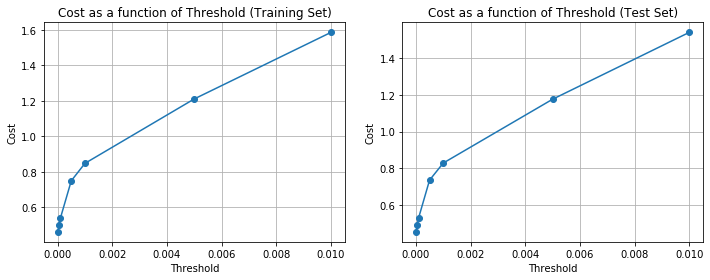

In [1213]:
lists2_train = sorted(expt2_cost_matrix_train.items())
lists2_test = sorted(expt2_cost_matrix_test.items())
x1_2, y1_2 = zip(*lists2_train)
x2_2, y2_2 = zip(*lists2_test)

figs2, axes2 = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
axes2[0].plot(x1_2, y1_2, 'o-')
axes2[0].set(xlabel='Threshold', ylabel='Cost',
       title='Cost as a function of Threshold (Training Set)')

axes2[1].plot(x2_2, y2_2, 'o-')
axes2[1].set(xlabel='Threshold', ylabel='Cost',
       title='Cost as a function of Threshold (Test Set)')
axes2[0].grid()
axes2[1].grid()
plt.tight_layout()
#figs2.savefig("expt2_1.png")

In [1214]:
# Best threshold is the one which has least cost; By looking at above plot, threshold = 0.00001
best_threshold = 0.00001
expt22_cost_matrix_train = {}
expt22_cost_matrix_test = {}

for i in range(500,4000,500):
    beta_22 = beta.copy()
    beta0_22 = beta_0.copy()
    iter22, b0_22,b22,c22 = gradient_descent(i, alpha_2, best_threshold, train_Y, train_X, beta0_22, beta_22, flag)
    expt22_cost_matrix_train[i] = c22
    test22_y_hat = linear_regression_model(test_X, b0_22[0:len(test_X)], b22)
    expt22_cost_matrix_test[i] = cost(test22_y_hat, test_Y)
#print(expt22_cost_matrix_train)
#print(expt22_cost_matrix_test)

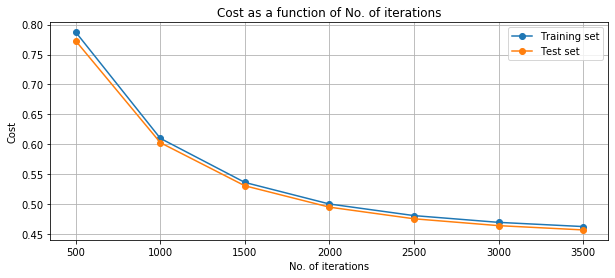

In [1215]:
lists22_train = sorted(expt22_cost_matrix_train.items())
lists22_test = sorted(expt22_cost_matrix_test.items())
x1_22, y1_22 = zip(*lists22_train)
x2_22, y2_22 = zip(*lists22_test)

figs22, axes22 = plt.subplots(nrows=1, ncols=1, figsize=(10,4))
axes22.plot(x1_22, y1_22, 'o-', label='Training set')
axes22.plot(x2_22, y2_22, 'o-', label='Test set')
axes22.set(xlabel='No. of iterations', ylabel='Cost',
       title='Cost as a function of No. of iterations')

axes22.grid()
axes22.legend(loc='upper right')
#figs22.savefig("expt2_2.png")

**EXPERIMENT - 3 BEGINS**

In [1216]:
## Experiment - 3
## NOTE: Every iteration returns a different result as random() is used; and we can't set seed to this function
import random

expt3_data = data_processed.copy(deep=True)

index = set()
while(len(index) < 10):
    index.add(random.randint(1,expt3_data.shape[1]-1))
index.add(0)

expt3_data = expt3_data.iloc[:,list(index)]

#For Logistic regression
expt3_data_logit = expt3_data.copy(deep=True)
for col in expt3_data_logit.columns:
    if(col != 'Appliances'):
        expt3_data_logit[col] = (expt3_data_logit[col] - expt3_data_logit[col].mean())/(expt3_data_logit[col].std())
        
for i in range(len(expt3_data_logit['Appliances'])):
    if(expt3_data_logit['Appliances'].values[i] <= 60):
        expt3_data_logit['Appliances'].values[i] = 0
    else:
        expt3_data_logit['Appliances'].values[i] = 1

from sklearn.model_selection import train_test_split
expt3_train_logit, expt3_test_logit = train_test_split(expt3_data_logit, test_size = 0.3, random_state = 40)

expt3_train_y_logit = expt3_train_logit[target_col]
expt3_train_x_logit = expt3_train_logit.loc[:, expt3_train_logit.columns!='Appliances']
expt3_test_x_logit = expt3_test_logit.loc[:, expt3_test_logit.columns!='Appliances']
expt3_test_y_logit = expt3_test_logit[target_col]

# Linear Regression continued
for cols in expt3_data.columns:
    expt3_data[cols] = (expt3_data[cols] - expt3_data[cols].mean())/(expt3_data[cols].std())

from sklearn.model_selection import train_test_split
expt3_train, expt3_test = train_test_split(expt3_data, test_size = 0.3, random_state = 40)

expt3_train_y = expt3_train[target_col]
expt3_train_x = expt3_train.loc[:, expt3_train.columns!='Appliances']

expt3_test_x = expt3_test.loc[:, expt3_test.columns!='Appliances']
expt3_test_y = expt3_test[target_col]

In [1217]:
expt3_data.columns

Index(['Appliances', 'T1', 'RH_1', 'RH_2', 'T3', 'T5', 'RH_5', 'RH_6', 'RH_9',
       'T_out', 'Tdewpoint'],
      dtype='object')

In [1218]:
#Linear Regression
#New data
beta0_3 = np.full((expt3_train_x.shape[0],1), beta_start)
beta_3 = np.full((expt3_train_x.shape[1],1), beta_start)
thres_3 = 0.00001
alpha_3 = 0.001
epochs_3 = 100000

expt3_train_X = expt3_train_x.to_numpy()
expt3_train_Y = expt3_train_y.to_numpy()
expt3_test_X = expt3_test_x.to_numpy()
expt3_test_Y = expt3_test_y.to_numpy()

n3,b0_3,b3,c3 = gradient_descent(epochs_3, alpha_3, thres_3, expt3_train_Y, expt3_train_X, beta0_3, beta_3, flag)
test3_y_hat = linear_regression_model(expt3_test_X, b0_3[0:len(expt3_test_X)], b3)
expt3_test_cost= cost(test3_y_hat, expt3_test_Y)
expt3_train_cost = c3

#Old data
beta0_3_old = beta_0.copy()
beta_3_old = beta.copy()
n3_old,b0_3_old,b3_old,c3_old = gradient_descent(epochs_3, alpha_3, thres_3, train_Y, train_X, beta0_3_old, beta_3_old, flag)
test3_y_hat_old = linear_regression_model(test_X, b0_3[0:len(test_X)], b3_old)
expt3_test_cost_old= cost(test3_y_hat_old, test_Y)
expt3_train_cost_old = c3_old

In [1219]:
#print(expt3_train_cost, expt3_test_cost)
#print(expt3_train_cost_old, expt3_test_cost_old)

In [1220]:
#Logistic Regression
#New data
expt3_logit_y_hat, expt3_logit = logistic_regression_model(expt3_train_x_logit, expt3_train_y_logit, expt3_test_x_logit, alpha_logit)
expt3_acc_new_test = expt3_logit.score(expt3_test_x_logit, expt3_test_y_logit)
expt3_acc_new_train = expt3_logit.score(expt3_train_x_logit, expt3_train_y_logit)

#Old data
expt3_logit_y_hat_old, expt3_logit_old = logistic_regression_model(logit_train_x, logit_train_y, logit_test_x, alpha_logit)
expt3_acc_old_test = expt3_logit_old.score(logit_test_x, logit_test_y)
expt3_acc_old_train = expt3_logit_old.score(logit_train_x, logit_train_y)
#print(expt3_acc_old_train, expt3_acc_old_test)
#print(expt3_acc_new_train, expt3_acc_new_test)

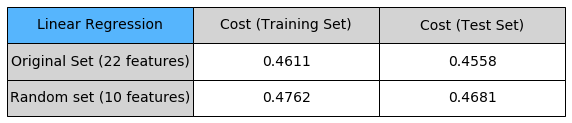

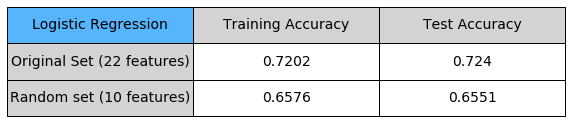

In [1221]:
fig3 = plt.figure(figsize=(10, 2))
ax3 = plt.subplot(111)
ax3.axis('off')

colLabels3 = ['Linear Regression','Cost (Training Set)', 'Cost (Test Set)']
cellText3 = [['Original Set (22 features)',round(expt3_train_cost_old,4), round(expt3_test_cost_old,4)],
            ['Random set (10 features)',round(expt3_train_cost,4), round(expt3_test_cost,4)]]
colColours3 = ['#56b5fd','lightgray','lightgray']
rowColours3 = [['lightgray','w','w'],['lightgray','w','w']]
tab3 = ax3.table(cellText=cellText3, colLabels=colLabels3, bbox=[0, 0, 1, 1], cellLoc = 'center', cellColours=rowColours3, colColours=colColours3)
tab3.auto_set_font_size(False)
tab3.set_fontsize(14)

fig33 = plt.figure(figsize=(10, 2))
ax33 = plt.subplot(111)
ax33.axis('off')

colLabels33 = ['Logistic Regression','Training Accuracy', 'Test Accuracy']
cellText33 = [['Original Set (22 features)',round(expt3_acc_old_train,4), round(expt3_acc_old_test,4)],
            ['Random set (10 features)',round(expt3_acc_new_train,4), round(expt3_acc_new_test,4)]]
colColours33 = ['#56b5fd','lightgray','lightgray']
rowColours33 = [['lightgray','w','w'],['lightgray','w','w']]
tab33 = ax33.table(cellText=cellText33, colLabels=colLabels33, bbox=[0, 0, 1, 1], cellLoc = 'center', cellColours=rowColours33, colColours=colColours33)
tab33.auto_set_font_size(False)
tab33.set_fontsize(14)
#fig3.savefig('expt3_linear.png')
#fig33.savefig('expt3_logistic.png')

**EXPERIMENT - 4 BEGINS**

In [1222]:
## Experiment - 4
## Columns are - 'T_out', 'Tdewpoint', 'RH_out', 'Press_mm_hg','Windspeed', 'Visibility', 'T1', 'T2', 'T3', 'T4'
expt4_data = data_processed.copy(deep=True)

cols_4 = target_col + ['RH_1','RH_2','RH_3','RH_4','RH_5','RH_6','RH_7','RH_8','RH_9','RH_out']
expt4_data = expt4_data[cols_4]

#For Logistic regression
expt4_data_logit = expt4_data.copy(deep=True)
for col in expt4_data_logit.columns:
    if(col != 'Appliances'):
        expt4_data_logit[col] = (expt4_data_logit[col] - expt4_data_logit[col].mean())/(expt4_data_logit[col].std())
        
for i in range(len(expt4_data_logit['Appliances'])):
    if(expt4_data_logit['Appliances'].values[i] <= 60):
        expt4_data_logit['Appliances'].values[i] = 0
    else:
        expt4_data_logit['Appliances'].values[i] = 1

from sklearn.model_selection import train_test_split
expt4_train_logit, expt4_test_logit = train_test_split(expt4_data_logit, test_size = 0.3, random_state = 40)

expt4_train_y_logit = expt4_train_logit[target_col]
expt4_train_x_logit = expt4_train_logit.loc[:, expt4_train_logit.columns!='Appliances']
expt4_test_x_logit = expt4_test_logit.loc[:, expt4_test_logit.columns!='Appliances']
expt4_test_y_logit = expt4_test_logit[target_col]

# Linear Regression continued
for cols in expt4_data.columns:
    expt4_data[cols] = (expt4_data[cols] - expt4_data[cols].mean())/(expt4_data[cols].std())

from sklearn.model_selection import train_test_split
expt4_train, expt4_test = train_test_split(expt4_data, test_size = 0.3, random_state = 40)

expt4_train_y = expt4_train[target_col]
expt4_train_x = expt4_train.loc[:, expt4_train.columns!='Appliances']

expt4_test_x = expt4_test.loc[:, expt4_test.columns!='Appliances']
expt4_test_y = expt4_test[target_col]

In [1223]:
expt4_data.columns

Index(['Appliances', 'RH_1', 'RH_2', 'RH_3', 'RH_4', 'RH_5', 'RH_6', 'RH_7',
       'RH_8', 'RH_9', 'RH_out'],
      dtype='object')

In [1224]:
#Linear Regression
#New data
beta0_4 = np.full((expt4_train_x.shape[0],1), beta_start)
beta_4 = np.full((expt4_train_x.shape[1],1), beta_start)
thres_4 = 0.00001
alpha_4 = 0.001
epochs_4 = 100000

expt4_train_X = expt4_train_x.to_numpy()
expt4_train_Y = expt4_train_y.to_numpy()
expt4_test_X = expt4_test_x.to_numpy()
expt4_test_Y = expt4_test_y.to_numpy()

n4,b0_4,b4,c4 = gradient_descent(epochs_4, alpha_4, thres_4, expt4_train_Y, expt4_train_X, beta0_4, beta_4, flag)
test4_y_hat = linear_regression_model(expt4_test_X, b0_4[0:len(expt4_test_X)], b4)
expt4_test_cost= cost(test4_y_hat, expt4_test_Y)
expt4_train_cost = c4

#Logistic Regression
#New data
expt4_logit_y_hat, expt4_logit = logistic_regression_model(expt4_train_x_logit, expt4_train_y_logit, expt4_test_x_logit, alpha_logit)
expt4_acc_new_train = expt4_logit.score(expt4_train_x_logit, expt4_train_y_logit)
expt4_acc_new_test = expt4_logit.score(expt4_test_x_logit, expt4_test_y_logit)

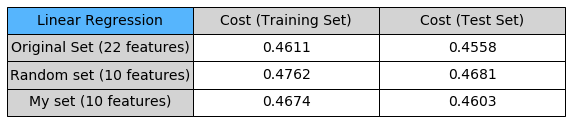

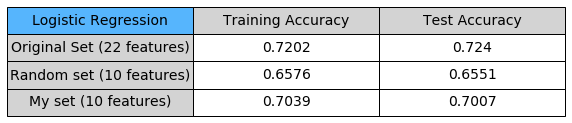

In [1225]:
fig4 = plt.figure(figsize=(10, 2))
ax4 = plt.subplot(111)
ax4.axis('off')

colLabels4 = ['Linear Regression','Cost (Training Set)', 'Cost (Test Set)']
cellText4 = [['Original Set (22 features)',round(expt3_train_cost_old,4), round(expt3_test_cost_old,4)],
            ['Random set (10 features)',round(expt3_train_cost,4), round(expt3_test_cost,4)],
            ['My set (10 features)',round(expt4_train_cost,4), round(expt4_test_cost,4)]]
colColours4 = ['#56b5fd','lightgray','lightgray']
rowColours4 = [['lightgray','w','w'],['lightgray','w','w'],['lightgray','w','w']]
tab4 = ax4.table(cellText=cellText4, colLabels=colLabels4, bbox=[0, 0, 1, 1], cellLoc = 'center', cellColours=rowColours4, colColours=colColours4)
tab4.auto_set_font_size(False)
tab4.set_fontsize(14)

fig44 = plt.figure(figsize=(10, 2))
ax44 = plt.subplot(111)
ax44.axis('off')

colLabels44 = ['Logistic Regression','Training Accuracy', 'Test Accuracy']
cellText44 = [['Original Set (22 features)',round(expt3_acc_old_train,4), round(expt3_acc_old_test,4)],
            ['Random set (10 features)',round(expt3_acc_new_train,4), round(expt3_acc_new_test,4)],
             ['My set (10 features)', round(expt4_acc_new_train,4), round(expt4_acc_new_test,4)]]
colColours44 = ['#56b5fd','lightgray','lightgray']
rowColours44 = [['lightgray','w','w'],['lightgray','w','w'], ['lightgray','w','w']]
tab44 = ax44.table(cellText=cellText44, colLabels=colLabels44, bbox=[0, 0, 1, 1], cellLoc = 'center', cellColours=rowColours44, colColours=colColours44)
tab44.auto_set_font_size(False)
tab44.set_fontsize(14)
#fig4.savefig('expt4_linear.png')
#fig44.savefig('expt4_logistic.png')